In [ ]:
"""
1. data preprocession: Normalization, One Hot encoder, Outliers...
2. models: LR, NN, SVM, KNN, RF
"""

In [2]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import time
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [3]:
data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', header=1, index_col=0)

In [4]:
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1


## Data Preprocessing

In [5]:
class Normalize:
    def __init__ (self, X):
        self.X = X
    
    def addX0(self, X):
        """
        @X : numpy matrix, dataset
        @does: add a bias term to the data
        @return :numpy matrix
        """
        return np.column_stack([np.ones([X.shape[0], 1]), X])
        
    def normalize(self, X):
        """
        @X : numpy matrix, dataset
        @does: normalize the data
        @return :numpy matrix, array, array
        """
        
        mean = np.mean(X, 0)
        std = np.std(X,0)
        X_norm = (X - mean)/std
        X_norm = self.addX0(X_norm)
        
        return X_norm, mean, std
    
    def normalizeTestData(self, X, trainMean, trainStd):
        """
        @X : numpy matrix, dataset
        @does: normalize the test data
        @return :numpy matrix
        """
        X_norm = (X - trainMean)/ trainStd
        X_norm = self.addX0(X_norm)
        
        return X_norm
    
    def standardize(self):
        min_col = np.min(self.X, 1)
        max_col = np.max(self.X, 1)
        X_scaled = (X - min_col) / (max_col - min_col)
        
        return X_scaled, max_col, min_col
    
    def standardizeTestData(self, X, max_col, min_col):
      
        return (X - min_col) / (max_col - min_col)

In [6]:
class SplitData:
    def __init__(self, X, y, train_size, valid_size, test_size, random_state=0):
        np.random.seed(random_state)

        self.X = X
        self.y = y
        self.train_size = train_size
        self.valid_size = valid_size
        self.test_size = 1 - train_size - valid_size

        if self.test_size != test_size:
          print('Sum of train_size, valid_size and test_size must be 1.')

    def train_test_split(self, X, y, test_size):
    
        train_size = int(X.shape[0] * (1 - test_size))
        train_index = np.random.choice(X.shape[0], train_size, replace=False)

        if isinstance(X, pd.DataFrame) and isinstance(y, pd.Series):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_test, y_test = X.drop(X.index[train_index]), y.drop(y.index[train_index])
        
        elif isinstance(X, np.ndarray) and isinstance(y, np.ndarray):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = np.delete(X, train_index, 0), np.delete(y, train_index, 0)
        
        else:
            print('Arguments X, y are allowed to be only numpy arrays or pandas dataframes.')
            print(f'Type of current input X: {type(X)}')
            print(f'Type of current input y: {type(y)}')
    
        return X_train, X_test, y_train, y_test
    
    def trainValidTestSplit(self):        
        X_train_valid, X_test, y_train_valid, y_test = self.train_test_split(self.X, self.y, test_size = self.test_size)
        X_train, X_valid, y_train, y_valid = self.train_test_split(X_train_valid, y_train_valid, test_size = self.valid_size/(1-self.test_size))
        return X_train, X_valid, X_test, y_train, y_valid, y_test

In [7]:
data, y = data.iloc[:, :-1], data.iloc[:, -1]

In [ ]:
# Outliers
data.loc[(data['EDUCATION'].isin([0, 5, 6])), 'EDUCATION'] = 4
data.loc[(data['MARRIAGE'].isin([0])), 'MARRIAGE'] = 3
data_edu = pd.get_dummies(data['EDUCATION'], prefix='EDUCATION')
data_mar = pd.get_dummies(data['MARRIAGE'], prefix='MARRIAGE')
data = pd.concat([data, data_edu], axis=1)
data = pd.concat([data, data_mar], axis=1)

# New reasonable features
data['BLC_AMT1'] = data['BILL_AMT1'] - data['PAY_AMT1']
data['BLC_AMT2'] = data['BILL_AMT2'] - data['PAY_AMT2']
data['BLC_AMT3'] = data['BILL_AMT3'] - data['PAY_AMT3']
data['BLC_AMT4'] = data['BILL_AMT4'] - data['PAY_AMT4']
data['BLC_AMT5'] = data['BILL_AMT5'] - data['PAY_AMT5']
data['BLC_AMT6'] = data['BILL_AMT6'] - data['PAY_AMT6']
data['BILL_SUM'] = data['BILL_AMT1'] + data['BILL_AMT2'] + data['BILL_AMT3'] + data['BILL_AMT4'] + data['BILL_AMT5'] + data['BILL_AMT6']
data['PAY_SUM'] = data['PAY_0'] + data['PAY_2'] + data['PAY_3'] + data['PAY_4'] + data['PAY_5'] + data['PAY_6']

In [9]:
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,BLC_AMT1,BLC_AMT2,BLC_AMT3,BLC_AMT4,BLC_AMT5,BLC_AMT6,BILL_SUM,PAY_SUM
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,3913,2413,689,0,0,0,7704,-2
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0,1,0,0,0,1,0,2682,725,1682,2272,3455,1261,17077,3
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,0,0,1,0,27721,12527,12559,13331,13948,10549,101653,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,1,0,0,1,0,0,44990,46214,48091,27214,27890,28547,231334,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,1,0,0,6617,-31011,25835,11940,18457,18452,109339,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,0,1,0,1,0,0,180448,172815,203362,84957,26237,14980,725349,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,0,1,0,0,1,0,-154,-1698,-5496,8850,5190,0,21182,-4
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,0,1,0,0,0,1,0,3565,3356,-19242,16678,18582,16257,70496,8


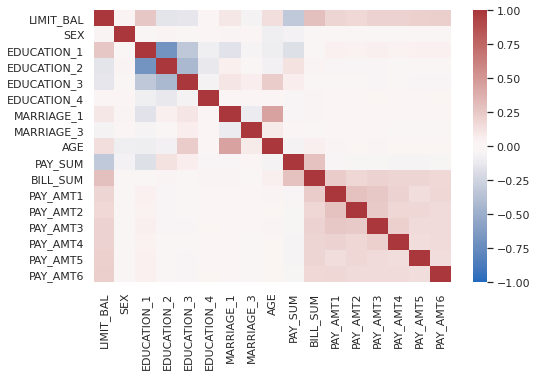

In [10]:
#Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
#Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BLC_AMT1','BLC_AMT2','BLC_AMT3','BLC_AMT4','BLC_AMT5','BLC_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
#Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_SUM','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_1','MARRIAGE_3','AGE','PAY_SUM','BILL_SUM','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

X = data[Selected_features]
plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=False, cmap="vlag", vmin = -1)
plt.show()

## Logistic Regression

In [11]:
class LogisticRegression:
    def __init__ (self, X, y, learningRate, tolerance, maxIteration = 50000, remove = False):
        self.X = X
        self.y = y
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
        self.remove = remove
    
  
 
    def add_X0(self,X):
        
        return np.column_stack([np.ones(X.shape[0],1),X])

    def sigmoid(self, z):
        sig = 1/ (1+np.exp(-z))
        
        return sig
    
    def costFunction(self, X, y):
        
        sig = self.sigmoid(X.dot(self.w))
        pred = y * np.log(sig) + (1-y) * np.log(1-sig)
        cost = -pred.sum()
        
        #or:
        
        #pred_ = np.log(np.ones(X.shape[0]) + np.exp(X.dot(self.w))) - X.dot(self.w).dot(y)
        #cost = pred_.sum()
        
        return cost
    
    def gradient(self,X,y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig-y).dot(X)
        
        return grad
    
    def plot_cost(self, cost_sequence):
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax =plt.subplots()
        ax.plot(t,s)
        ax.set(xlabel='iterations', ylabel = 'cost', title ='cost trend')
        
        
        ax.grid()
        plt.legend(bbox_to_anchor=(1.05,1), loc =2, shadow =True)
        plt.show
        
    def gradientDescent(self, X, y):
        
        cost_sequence = []
        
        last_cost = float('inf')
        
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w -self.learningRate * self.gradient(X,y)
            current_cost = self.costFunction(X,y)
            #print(current_cost)
            diff = last_cost - current_cost
            last_cost = current_cost
            cost_sequence.append(current_cost)
            
            if diff < self.tolerance:
                print('The model stopped - no futher improvement')
                break
                
        self.plot_cost(cost_sequence)
        return
    
    def predict(self,X,y):
        sig = self.sigmoid(X.dot(self.w))
        y_hat = np.around(sig)
        accuracy, recall, precision = self.evaluate(y, y_hat)
        
        print('Accuracy:', accuracy)
        print('Recall:',recall)
        print('Precison:',precision)
    
    def evaluate(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat == 1)
        
        accuracy = ( y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        return accuracy, recall, precision
    
    
    def run_model(self):
        self.w = np.ones(self.X.shape[1], dtype = np.float128) * 0
        self.gradientDescent(self.X,self.y)
        
        print(self.w)
        
        self.predict(self.X,self.y)

In [12]:
Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_3','AGE','PAY_SUM','BILL_SUM','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

X = data[Selected_features]
splitData = SplitData(X, y, train_size=0.6, valid_size=0.2, test_size=0.2, random_state=0)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitData.trainValidTestSplit()
normalize = Normalize(X_train)
X_train,X_mean,X_std = normalize.normalize(X_train)
X_test = normalize.normalizeTestData(X_test,X_mean,X_std)


100%|██████████| 10000/10000 [02:38<00:00, 63.16it/s]
No handles with labels found to put in legend.


[-1.42341562 -0.09204579 -0.07020574  0.04482635 -0.01796765  0.00300282
 -0.11052498  0.08465298 -0.00152462  0.04645248  0.67579177 -0.08503285
 -0.20251947 -0.36483689 -0.03382724 -0.16575202 -0.0407326  -0.05185848]
Accuracy: 0.7967777777777778
Recall: 0.16625248508946322
Precison: 0.6882716049382716
Accuracy: 0.7926666666666666
Recall: 0.16124260355029585
Precison: 0.6646341463414634


Time to run Logistic Regression model is 158.38763308525085


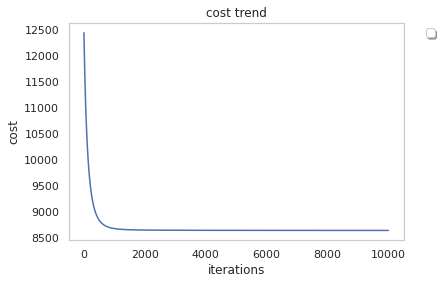

In [13]:
start_time = time.time()

LR = LogisticRegression(X_train, y_train ,learningRate = 0.1e-5, tolerance =0, maxIteration = 10000)
LR.run_model()
LR.predict(X_test, y_test)

end_time = time.time()
print('\n')
print(f'Time to run Logistic Regression model is {end_time - start_time}')

## Neural Network

In [14]:
class NeuralNetwork:

    
    def __init__(self, X, y, layers, learning_rate=0.2, epochs=100000):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.epochs = epochs
        # Set weights
        self.weights = []
        # range of weight values (-1,1)
        # input and hidden layers - random((2+1, 2+1)) : 3 x 3
        for i in range(1, len(layers) - 1):
            r = 2*np.random.random((layers[i-1] + 1, layers[i] + 1)) -1
            self.weights.append(r)
        # output layer - random((2+1, 1)) : 3 x 1
        r = 2*np.random.random( (layers[i] + 1, layers[i+1])) - 1
        self.weights.append(r)
    
    def sigmoid(self,x):
        return 1.0/(1.0 + np.exp(-x))

    def sigmoid_prime(self,x):
        return self.sigmoid(x)*(1.0-self.sigmoid(x))


    
    def fit(self, X, y):
        # Add column of ones to X
        # This is to add the bias unit to the input layer
        ones = np.atleast_2d(np.ones(X.shape[0]))
        X = np.concatenate((ones.T, X), axis=1)
         
        for k in range(self.epochs):

            i = np.random.randint(X.shape[0])
            a = [X[i]]
            if isinstance(y, pd.Series):
              y = y.to_numpy()
            for l in range(len(self.weights)):
                    dot_value = np.dot(a[l], self.weights[l])
                    activation = self.sigmoid(dot_value)
                    a.append(activation)
            # output layer
            error = y[i] - a[len(a)-1]
            deltas = [error * self.sigmoid_prime(a[len(a)-1])]

            # we need to begin at the second to last layer 
            # (a layer before the output layer)
            for l in range(len(a) - 2, 0, -1): 
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.sigmoid_prime(a[l]))

            # reverse
            # [level3(output)->level2(hidden)]  => [level2(hidden)->level3(output)]
            deltas.reverse()

            # backpropagation
            # 1. Multiply its output delta and input activation 
            #    to get the gradient of the weight.
            # 2. Subtract a ratio (percentage) of the gradient from the weight.
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += self.learning_rate * layer.T.dot(delta)

    def predict(self, x): 
        a = np.concatenate((np.ones(1).T, np.array(x)), axis=0)      
        for l in range(0, len(self.weights)):
            a = self.sigmoid(np.dot(a, self.weights[l]))
        return a
    
    
    def evaluate(self, y, y_hat):
        y = (y == 1)
        y_hat = (y_hat == 1)
        print(type(y == y_hat))
        accuracy = ( y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        return accuracy, recall, precision
    
    
    def run_model(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        
        y_hat = []
        for e in X:
            y_hat = np.concatenate((y_hat,self.predict(e)))
        y_hat = np.where(y_hat > 0.5, 1, y_hat)
        y_hat = np.where(y_hat <= 0.5, 0, y_hat)
        y = y.to_numpy()

        accuracy, recall, precision = self.evaluate(y, y_hat)
        
        print('Accuracy:', accuracy)
        print('Recall:', recall)
        print('Precison:', precision)

In [15]:
Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_1','MARRIAGE_2','MARRIAGE_3','AGE','PAY_SUM','BILL_SUM','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

X = data[Selected_features]
splitData = SplitData(X, y, train_size=0.6, valid_size=0.2, test_size=0.2, random_state=0)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitData.trainValidTestSplit()
normalize = Normalize(X_train)
X_train,X_mean,X_std = normalize.normalize(X_train)
X_test = normalize.normalizeTestData(X_test,X_mean,X_std)

In [16]:
start_time = time.time()

nn = NeuralNetwork(X_train,y_train,[19,13,1])
nn.fit(X_train,y_train)
nn.run_model(X_train,y_train)
nn.run_model(X_test,y_test)

end_time = time.time()
print('\n')
print(f'Time to run Neural Network model is {end_time - start_time}')

<class 'numpy.ndarray'>
Accuracy: 0.7991666666666667
Recall: 0.3225646123260437
Precison: 0.5935070873342478
<class 'numpy.ndarray'>
Accuracy: 0.7975
Recall: 0.3217455621301775
Precison: 0.5934515688949522


Time to run Neural Network model is 8.761599063873291


## SVM

In [17]:
class SVM:
    def __init__(self, learningRate=0.004, _lambda=0.001, n_iters=150):
        self.learningRate = learningRate
        self._lambda = _lambda
        self.n_iters = n_iters
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        n_samples, n_features = X.shape[0], X.shape[1]
        y = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                
                if condition:
                    self.w -= self.learningRate * (2 * self._lambda * self.w)
                else:
                    self.w -= self.learningRate * (2 * self._lambda * self.w) - np.dot(y[idx], x_i)
                    self.b -= self.learningRate * (-y[idx])
                    
    def predict(self, X):
        y_hat = np.sign(np.dot(X, self.w) + self.b)
        y_hat[np.where(y_hat == -1)] = 0
        return y_hat
    
    def evaluate(self, y, y_hat):
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        if isinstance(y_hat, pd.Series):
            y_hat = y_hat.to_numpy()
        
        y = (y == 1)
        y_hat = (y_hat == 1)
        
        accuracy = ( y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()

        print('Accuracy:', accuracy)
        print('Recall:', recall)
        print('Precison:', precision)

        return accuracy, recall, precision

In [18]:
Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
X = data[Selected_features]
splitData = SplitData(X, y, train_size=0.6, valid_size=0.2, test_size=0.2, random_state=0)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitData.trainValidTestSplit()

In [19]:
start_time = time.time()

svm_model = SVM()
svm_model.fit(X_train, y_train)
y_predict = svm_model.predict(X_test)
svm_model.evaluate(y_test, y_predict)

end_time = time.time()
print('\n')
print(f'Time to run SVM model is {end_time - start_time}')

Accuracy: 0.7736666666666666
Recall: 0.008136094674556213
Precison: 0.39285714285714285


Time to run SVM model is 36.582040548324585


## KNN

In [20]:
class knnClassifier:
    def __init__(self, n_neighbors, metric='minkowski', p=2, weight='uniform'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.weight = weight
        self.p = p
    
    def minkowski_metric(self, vec1: np.array, vec2: np.array):
        """
        p = 1: Manhattan Distance
        p = 2: Euclidean Distance
        vec1, vec2: numpy array
        formula: sum(abs(v) ** p) ** (1./p)
        """
        v = vec1 - vec2
        return np.linalg.norm(v, ord=self.p)
    
    def get_nearest_neighbor(self, vec1):
        dist = {}
        
        for index, vec2 in enumerate(self.X):
            dist[index] = self.minkowski_metric(vec1, vec2)
            
        neighbors_index = sorted(dist, key=dist.get)[:self.n_neighbors]
        neighbors = self.y[neighbors_index]
        
        if self.weight == 'distance':
            w = np.array([dist[i] for i in neighbors_index])
            best_choice = int(np.dot(neighbors, w) / sum(w) >= 0.5)
        else:
            best_choice = int(sum(neighbors) / self.n_neighbors >= 0.5)
        
        return best_choice
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
            
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        self.X = X
        self.y = y
    
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        
        y_hat = np.zeros(len(X))
        for index, vec in enumerate(X):
            y_hat[index] = self.get_nearest_neighbor(vec)
        return y_hat
    
    def evaluate(self, y, y_hat):
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        if isinstance(y_hat, pd.Series):
            y_hat = y_hat.to_numpy()
        
        y = (y == 1)
        y_hat = (y_hat == 1)
        
        accuracy = ( y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()

        print('Accuracy:', accuracy)
        print('Recall:', recall)
        print('Precison:', precision)

        return accuracy, recall, precision

In [21]:
Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_1','MARRIAGE_2','MARRIAGE_3','AGE','PAY_SUM','BILL_SUM','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

X = data[Selected_features]
splitData = SplitData(X, y, train_size=0.6, valid_size=0.2, test_size=0.2, random_state=0)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitData.trainValidTestSplit()
normalize = Normalize(X_train)
X_train, X_mean, X_std = normalize.normalize(X_train)
X_test = normalize.normalizeTestData(X_test, X_mean, X_std)

In [22]:
start_time = time.time()

knn_model = knnClassifier(n_neighbors=5, p=2, weight='uniform')
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
knn_model.evaluate(y_test, y_pred)

end_time = time.time()
print('\n')
print(f'Time to run KNN model is {end_time - start_time}')

Accuracy: 0.7786666666666666
Recall: 0.28994082840236685
Precison: 0.5157894736842106


Time to run KNN model is 1037.0364663600922


## Random Forest

In [23]:
class randomForest:
    def __init__(self, n_estimators=5, max_samples=None, max_features='sqrt', max_depth=100, max_vals=100, split_cont='uniform', random_state=0):
        """
        max_features: {'sqrt', 'log2'}; number of features to build subtree, default is 'sqrt'
        split_cont: {'uniform', 'random'}: the way to deal with large continous varialbe set, default is 'uniform'
        """
        self.max_samples = max_samples
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.max_vals = max_vals
        self.split_cont = split_cont
        
    def build_subtree(self, features, subset, depth):
        features = self.update_features(features, subset)
        
        if self.is_leaf(features, subset, depth):
            return stats.mode(self.y[subset]).mode[0]
        
        # node: {'col': col_index, 'val': split values, 'left' and 'right': groups of subset}
        node = self.get_split_feature(features, subset)
        left_group, right_group = node['left'], node['right']

        # node: {'col': col_index, 'val': split values, 'left' and 'right': next node or classification}
        left = self.build_subtree(features, left_group, depth + 1)
        right = self.build_subtree(features, right_group, depth + 1)
        if isinstance(left, dict):
            node['left'] = dict(left)
        else:
            node['left'] = left
        if isinstance(right, dict):
            node['right'] = dict(right)
        else:
            node['right'] = right
        
        return node
    
    def get_split_feature(self, features, subset):
        node = {}
        min_gini = float('inf')
        node['col'] = None
        node['val'] = None
        
        for index in features:
            gini, val, left, right = self.get_split_val(index, subset)
            
            if gini < min_gini:
                min_gini = gini
                node['col'] = index
                node['val'] = val
                node['left'] = left
                node['right'] = right
                
        return node
    
    def get_split_val(self, feature, subset):
        vals = sorted(set(self.X[subset, feature]))
        vals_set = (np.array(vals[:-1]) + np.array(vals[1:])) / 2
        
        if len(vals_set) > self.max_vals:
            if self.split_cont == 'random':
                vals_set = np.random.choice(list(vals_set), self.max_vals, replace=False)
            else:
                sep = int(len(vals_set) / self.max_vals) + 1
                vals_set = list(vals_set)[::sep]
    
        min_gini = float('inf')
        split_val, left, right = None, None, None
        
        for val in vals_set:
            s1 = subset[np.where(self.X[subset, feature] < val)]
            s2 = subset[np.where(self.X[subset, feature] >= val)]
            gini = self.compute_gini([self.y[s1], self.y[s2]])
            
            if gini < min_gini:
                min_gini = gini
                split_val = val
                left, right = s1, s2
                
        return min_gini, split_val, left, right
        
        
    def update_features(self, features, subset):
        new_features = []
        for index in features:
            n_values = len(set(self.X[subset, index]))
            if n_values > 1:
                new_features.append(index)
        
        return new_features
        
    def is_leaf(self, features, subset, depth):
        n_classes = len(set(self.y[subset]))
        if not features or n_classes == 1 or depth >= self.max_depth:
            return True
        else:
            return False
        
    def compute_gini(self, subgroups):
        """
        @subgroups: groups of predictions
        """
        
        classes = set(self.y)
        total_size = sum([len(g) for g in subgroups])
        gini = 0.
        
        for group in subgroups:
            group_size = len(group)
            score = 0
            if not group_size:
                continue
            
            for label in classes:
                p = sum(group == label) / group_size
                score += p ** 2
            
            gini += (1 - score) * (group_size / total_size)
        
        return gini
    
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        self.X, self.y = X, y
        
        if self.max_features == 'log2':
            self.n_features = int(math.log2(self.X.shape[1]))
        elif self.max_features == 'sqrt':
            self.n_features = int(math.sqrt(self.X.shape[1]))
        else:
            self.n_features = self.max_features
            
        if not self.max_samples:
            self.n_samples = self.X.shape[0]
            
        for i in range(self.n_estimators):
            np.random.seed(i + self.random_state)
            features = np.random.choice(range(self.X.shape[1]), self.n_features, replace=False)
            subset = np.random.choice(range(self.X.shape[0]), self.n_samples, replace=True)
            subtree = self.build_subtree(features, subset, 1)
            print(f'Done with subtree {i}')
            self.trees.append(subtree) 
    
    def cart_predict(self, rule, row):
        if not isinstance(rule, dict):
            return rule
        
        if row[rule['col']] < rule['val']:
            rule = rule['left']
            
        else:
            rule = rule['right']
        
        prediction = self.cart_predict(rule, row)
        
        return prediction
    
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
            
        y_hat = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            pred = []
            for t in self.trees:
                pred.append(self.cart_predict(t, X[i]))
                
            y_hat[i] = stats.mode(pred).mode[0]
        
        return y_hat
    
    def evaluate(self, y, y_hat):
        if isinstance(y, pd.Series):
            y = y.to_numpy()
            
        if isinstance(y_hat, pd.Series):
            y_hat = y_hat.to_numpy()
        
        y = (y == 1)
        y_hat = (y_hat == 1)
        
        accuracy = ( y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()

        print('Accuracy:', accuracy)
        print('Recall:', recall)
        print('Precison:',precision)
        
        return accuracy, recall, precision

In [24]:
Selected_features = ['LIMIT_BAL', 'SEX', 'EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
X = data[Selected_features]
splitData = SplitData(X, y, train_size=0.6, valid_size=0.2, test_size=0.2, random_state=0)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitData.trainValidTestSplit()

In [25]:
start_time = time.time()

rf = randomForest(n_estimators=3, max_depth=3, max_vals=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.evaluate(y_test, y_pred)

end_time = time.time()
print('\n')
print(f'Time to run Random Forest model is {end_time - start_time}')

Done with subtree 0
Done with subtree 1
Done with subtree 2
Accuracy: 0.7778333333333334
Recall: 0.028846153846153848
Precison: 0.6610169491525424


Time to run Random Forest model is 19.039352655410767
